In [9]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from pylab import rcParams
rcParams['figure.figsize'] = 25, 10
import numpy as np 
import dill as pickle
import os
import random
import datetime 
import sys 
import seaborn as sns
from einops import rearrange
import pandas as pd
import matplotlib as mpl
from matplotlib.patches import Rectangle
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.flasso.Replicate import Replicate
from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_cosines import get_cosines
from codes.plotting.supportrecovery import plot_watch3,plot_reg_path_ax_lambdasearch_customcolors_norm,plot_reg_path_ax_lambdasearch_customcolors
from codes.plotting.cosines import plot_cosines
from codes.plotting.supportrecovery import plot_watch_custom
from itertools import combinations

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

In [3]:
nreps= 25
dim = 2
#from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d

# with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/ethanol/ethanol_0219_diagramreplicates_small.pkl' ,
#          'rb') as loader:
#      replicates = pickle.load(loader)

with open('/Users/samsonkoelle/manifoldflasso_jmlr/untracked_data/embeddings/malonaldehyde/malonaldehyde_0219_diagramreplicates_small.pkl' ,
         'rb') as loader:
     replicates = pickle.load(loader)         

/Users/samsonkoelle/manifoldflasso_jmlr


In [8]:
from codes.otherfunctions.utils import get_min_min, get_mu_full_ind, get_kappa_s,get_gamma_max


nreps = 25
nsel = 100
min_mins = np.zeros(nreps, dtype = np.float64)
mus = np.zeros(nreps, dtype = np.float64)
kappas = np.zeros(nreps, dtype = np.float64)
gamma_maxs = np.zeros(nreps, dtype = np.float64)
n = nsel
for r in range(nreps):
    print(r)
    inds = np.asarray([5,11])#sel_tol[r]
    dg_M = replicates[r].dg_M
    min_mins[r]  = get_min_min(dg_M[:,:,inds]*n)
    mus[r] = get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, inds)
    kappas[r] = get_kappa_s(replicates[r].dg_M[:,:,inds[0]:(inds[0]+1)]*n)
    gamma_maxs[r] = get_gamma_max(dg_M[:,:,inds]*np.sqrt(n ) )

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [10]:
columns = np.asarray([r'$\bar \mu$', r'$\sigma_\mu$',
                     r'$\bar {\kappa_S}$', r'$\sigma_{\kappa_S}$',
                     r'$\bar {\gamma_{\text{max}}}$', r'$\sigma_{\gamma_{\text{max}}}$',
                     r'$\bar {\min_{i = 1}^{n} \min_{j \in S } ||x_{ij}|| }$', r'$\sigma_\mu$'])

df_mal_apriori = pd.DataFrame(np.asarray([np.mean(mus), np.sqrt(np.var(mus)), 
                    np.mean(kappas), np.sqrt(np.var(kappas)),
                    np.mean(gamma_maxs),np.sqrt(np.var(gamma_maxs)),
                    np.mean(min_mins),np.sqrt(np.var(min_mins))]).transpose(), index = columns).transpose()

In [12]:
df_mal_apriori.to_csv('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/maldiagramparam.csv')


In [4]:
cosine = get_cosines(np.swapaxes(replicates[0].dg_M,1,2))
cosine_abs = np.mean(np.abs(cosine), axis = 0)

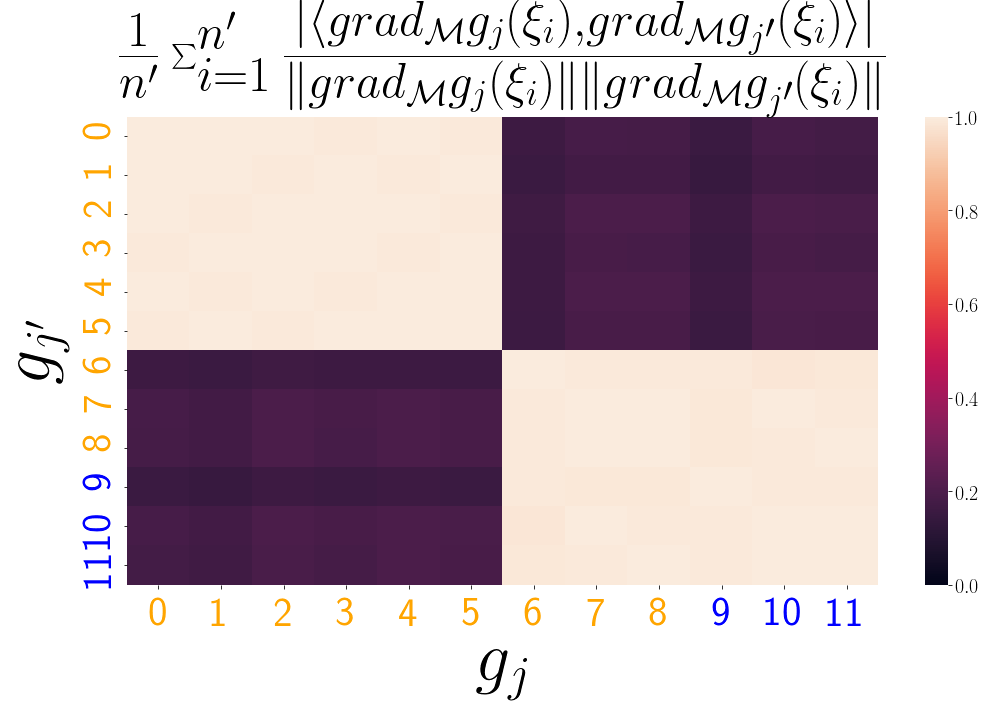

In [5]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_cosines(cosine_abs, axes_all, colors)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal12_cosines')

In [6]:
nreps = 25
sel_l = np.zeros(nreps, dtype = int)
sel = {}
for r in range(nreps):
    cs = rearrange(np.asarray(list(replicates[r].results[1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(replicates[r].results[1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis
    
    sel_l[r] = np.where(xaxis_reorder ==  replicates[r].results[0])[0][0]
    sel[r] = np.where(np.linalg.norm(replicates[r].cs_reorder, axis = tuple([1,2,]))[sel_l[r]] !=0.)[0]

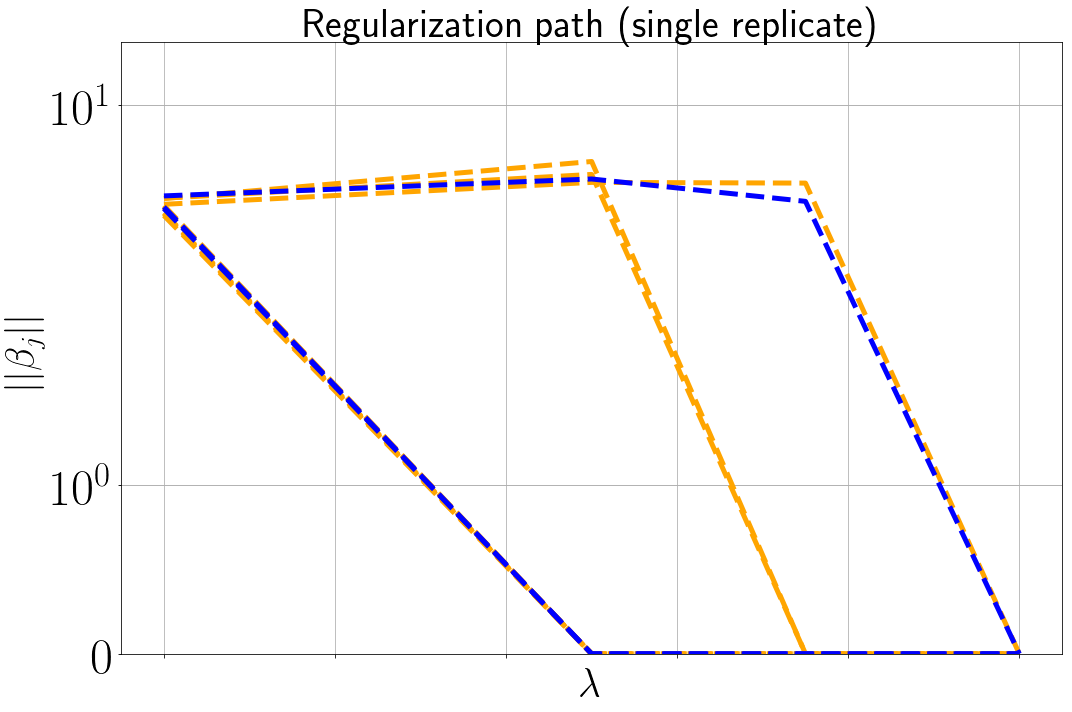

In [7]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(15, 10))

colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder / replicates[0].xaxis_reorder.max(), fig,colors)#axes_all[0].imshow(asdf)
axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
axes_all.set_xlabel(r'$\lambda$', fontsize = 40)
axes_all.set_xticklabels([])
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal12_replicate')
plt.tight_layout()

In [7]:
#sel_eth = {}
toplot = np.zeros((12,12))
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    toplot[sel[r][0], sel[r][1]] += 1
    toplot[sel[r][1], sel[r][0]] += 1

1.0 0.0
0.8660254037844387 0.49999999999999994
0.5000000000000001 0.8660254037844386
6.123233995736766e-17 1.0
-0.4999999999999998 0.8660254037844388
-0.8660254037844385 0.5000000000000003
-1.0 1.2246467991473532e-16
-0.8660254037844388 -0.4999999999999998
-0.5000000000000004 -0.8660254037844384
-1.8369701987210297e-16 -1.0
0.4999999999999993 -0.866025403784439
0.8660254037844384 -0.5000000000000004


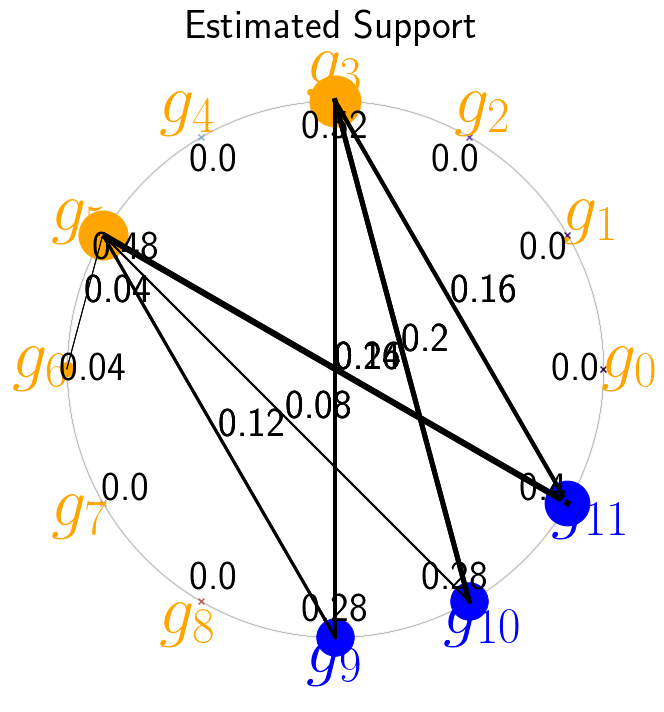

In [8]:
fig, axes_all = plt.subplots(figsize=(15, 10))

#[ax.set_axis_off() for ax in axarr.ravel()]
#colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_watch_custom(toplot, 12, axes_all,colors, nreps)
axes_all.set_title('Estimated Support', fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal12_support')

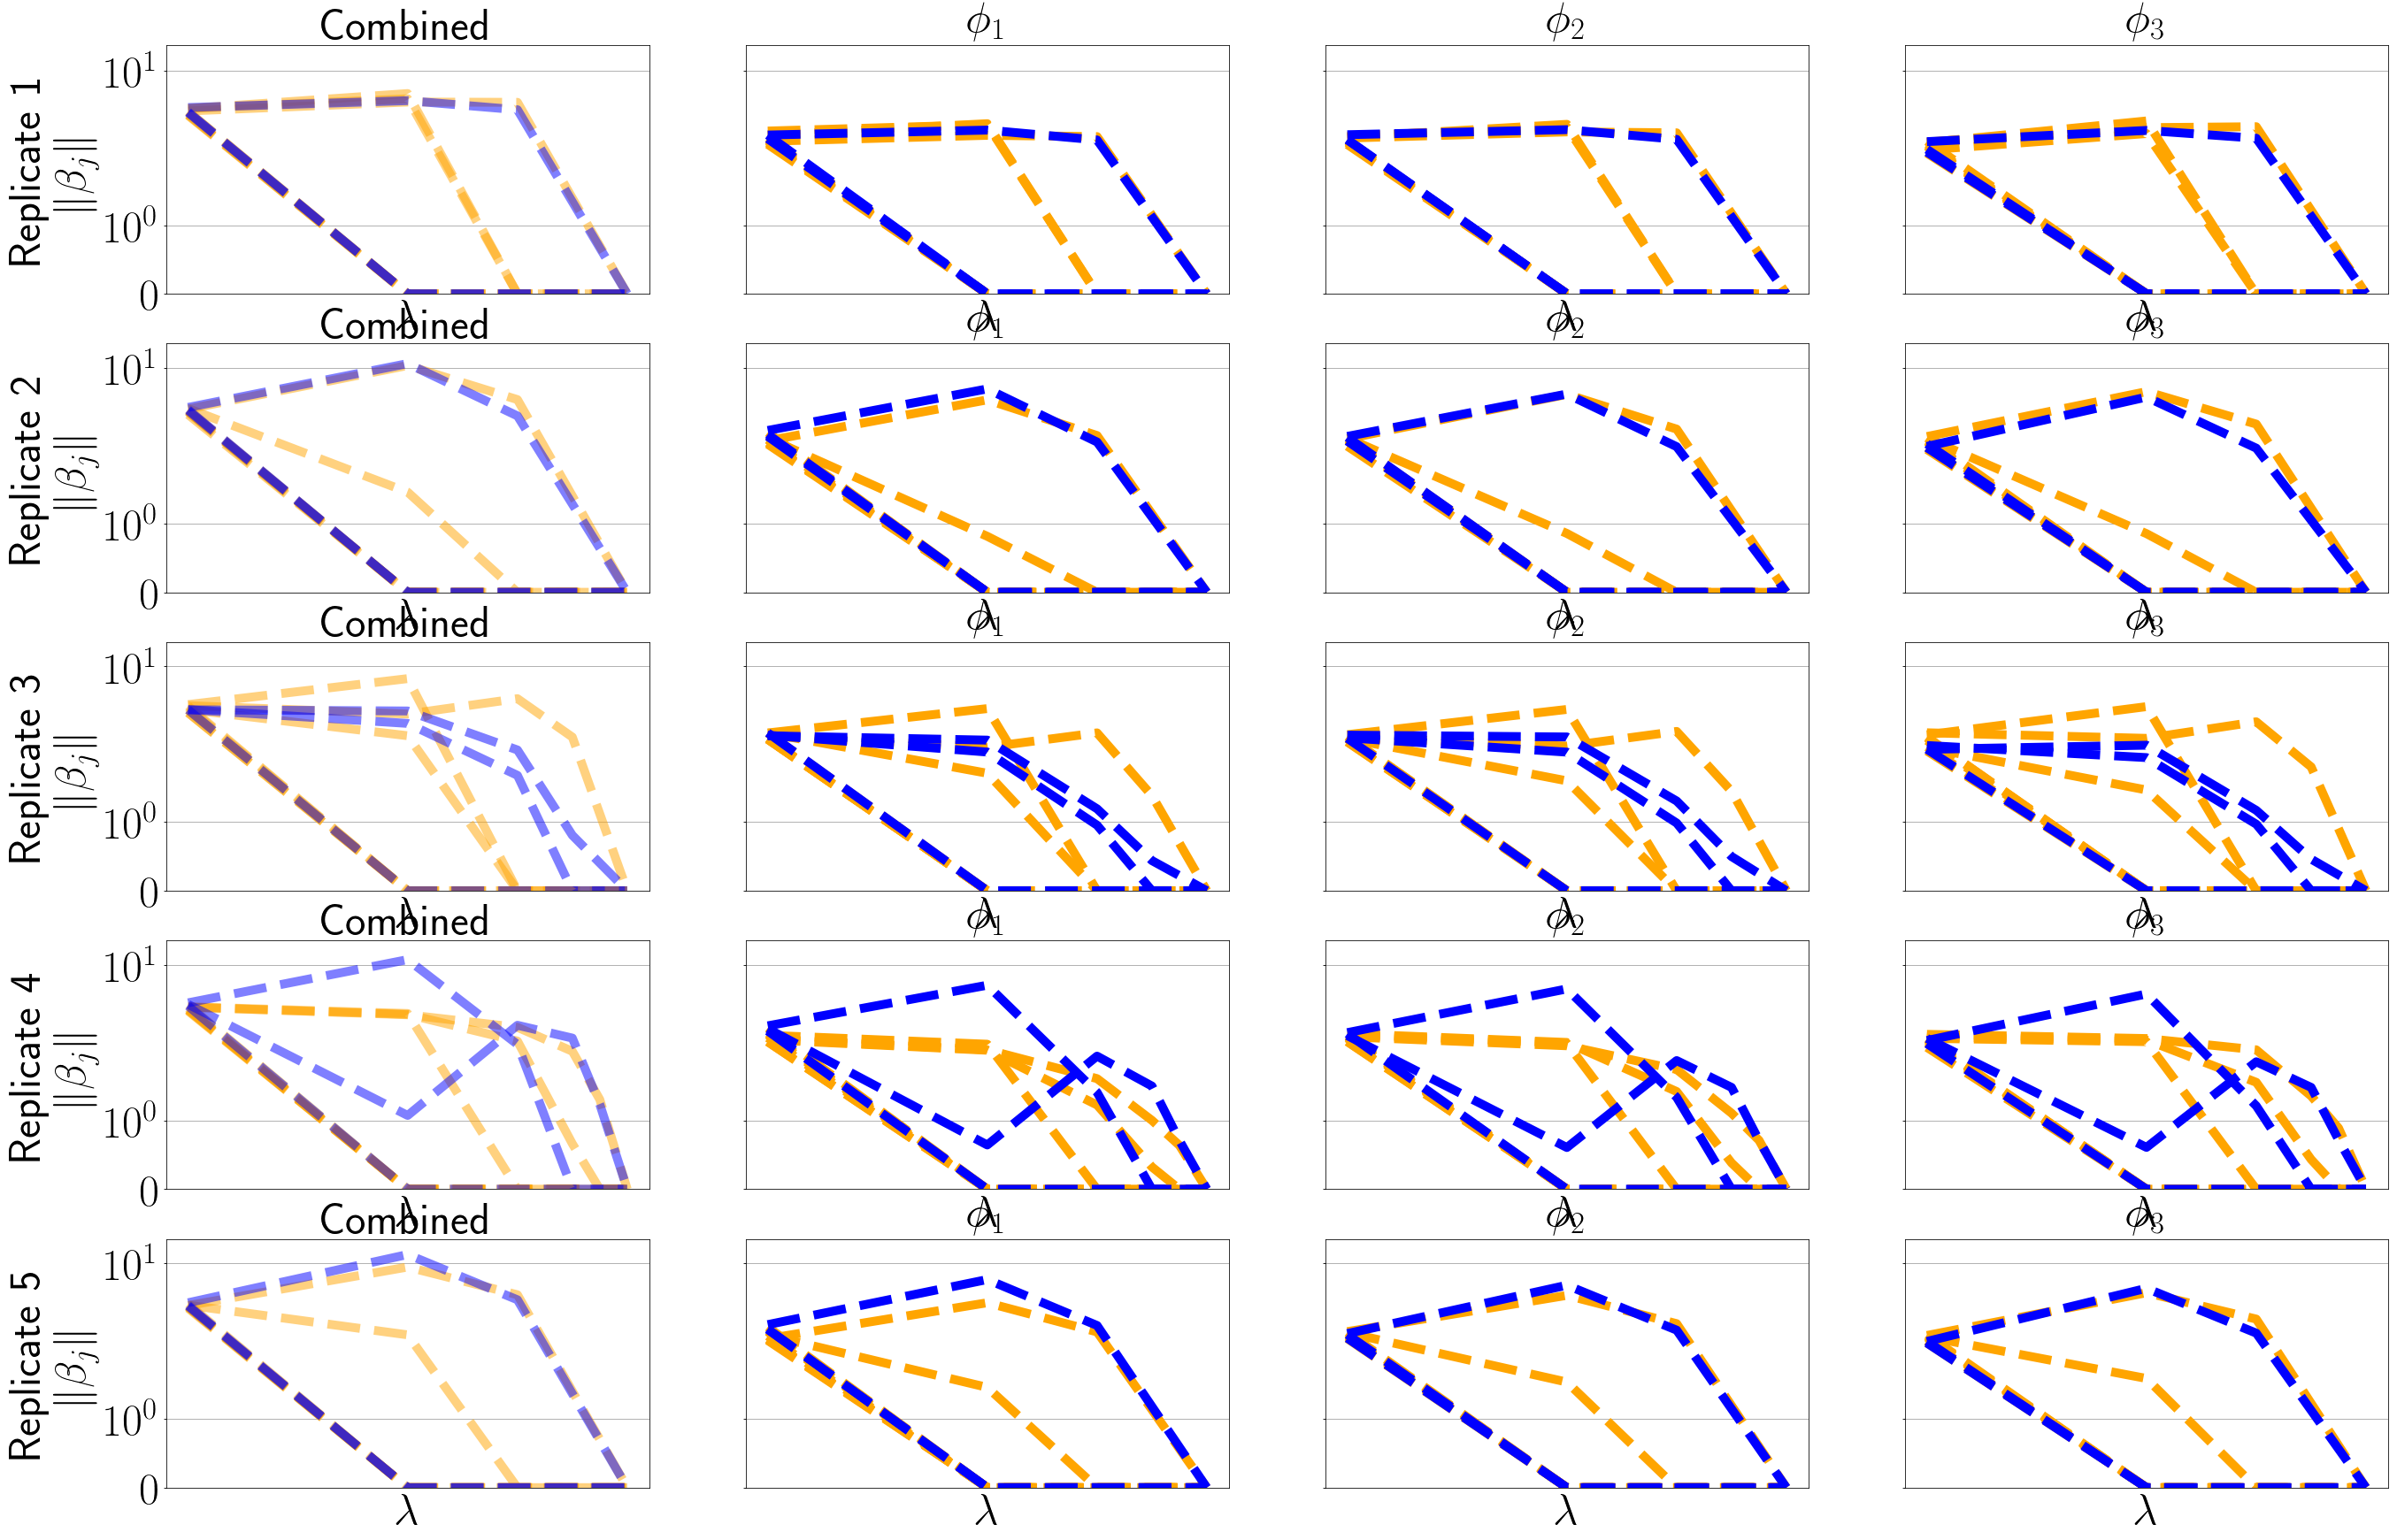

In [9]:
fig, axes_all = plt.subplots(5,4,figsize = (45,30))
colors = np.hstack([np.repeat('orange',9), np.repeat('blue',3)])
plot_reg_path_ax_lambdasearch_customcolors(axes_all[0], replicates[0].cs_reorder, replicates[0].xaxis_reorder , fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[1], replicates[1].cs_reorder, replicates[1].xaxis_reorder , fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[2], replicates[2].cs_reorder, replicates[2].xaxis_reorder , fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[3], replicates[3].cs_reorder, replicates[3].xaxis_reorder , fig,colors)
plot_reg_path_ax_lambdasearch_customcolors(axes_all[4], replicates[4].cs_reorder, replicates[4].xaxis_reorder , fig,colors)
axes_all[0,0].set_ylabel('Replicate 1 \n' + r'$\|\beta_j\|$')
axes_all[1,0].set_ylabel('Replicate 2 \n' + r'$\|\beta_j\|$')
axes_all[2,0].set_ylabel('Replicate 3 \n' + r'$\|\beta_j\|$')
axes_all[3,0].set_ylabel('Replicate 4 \n' + r'$\|\beta_j\|$')
axes_all[4,0].set_ylabel('Replicate 5 \n' + r'$\|\beta_j\|$')
plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/mal_phis_regpath')